# Анализ A/B-теста
### Цель проверка  гипотез для А/В теста и анализ результатов А/В тестирования
<br>.
### Задачи:
1. выполнить приоритезацию гипотез фреймфорками Reach, Impact, Confidence, Effort;<br>
2. выполнить статистическую обработку данных,  найти статистические различия в "сырых" и обработанных данных;<br>
3. проанализировать АВ-тест по следующим показателям: динамика кумулятивного среднего чека и конверсии, изменение количества заказов по пользователям;<br> 
4. сделать общие выводы и рекомендации по А/В тестированию.

In [1]:
import pandas as pd
import scipy.stats as st
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)

### 1. Приоритизация гипотез 
 
    Применим фреймворки ICE и RICE для приоритизации гипотез, отсортируем их по убыванию приоритета.
Проанализируем, как изменилась приоритизация гипотез при применении RICE вместо ICE, дадим объяснение.

In [2]:
# убреру заглавные буквы в названии столбцов
hypothesis.columns = map(str.lower, hypothesis.columns)
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [3]:
# рассчитаем ice и rice, выведем на экран в виде таблицы с сортировкой по rice
hypothesis['ice'] = (
    (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
    )

hypothesis[['hypothesis', 'ice' ]].sort_values(by='ice', ascending=False)

hypothesis['rice'] = (
    (hypothesis['impact'] * hypothesis['confidence'] * hypothesis['reach']) / hypothesis['efforts']
    )

hypothesis[['hypothesis', 'ice' , 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.0


#### Вывод

Как мы видим из таблицы, ice и rice одной гипотезы отличаются. Это можно объяснить учетом фактора reach - охвата. Гипотезы 8, 0 и 7 имеют самый высокий ice, но за счет более высокого охвата, лидируют гипотезы 7, 2, 0 и 6. Гипотезы 0 и 7 имеют одновременно высокие ice и rice, возможно, их дальнейшей разработкой следует заняться в первую очередь. Поэтому при дальнейшем выборе гипотез для тестирования менджер будет учитывать кроткосрочные и долгострочные цели по развитию продукта и полученные нами результаты.

In [4]:
orders.head()
# переименую названия столбцов, чтобы убрать заглавные буквы
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
orders.describe()

visitors['date'] = (
    visitors['date']
    .map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
)



Как мы видим, данные по сумме покупок неоднородны: средний чек находится в районе 3000 руб, однако за счет дорогих покупок среднее арифметическое находтся в районе 8500 руб. Такие выбросы будут сильно искажать данные, от них избавимся позже.

In [5]:
visitors.head()
visitors.describe()

orders['date'] = (
    orders['date']
    .map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d')))

### Проверка распределения данных стоимостей заказов
 
Проверим распределение суммы чеков на нормальность

In [6]:
# проверим распределение данных с помощью критерия Шапиро-Уилка
sample1 = orders[orders['group'] == 'A']['revenue']
sample2 = orders[orders['group'] == 'B']['revenue']

alpha = 0.05

results = st.shapiro(sample1)
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 
    
results = st.shapiro(sample2)
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  1.739703399801917e-34
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


 
Как мы видим, распределение не нормально в двух выборках, тест Стьюдента для двух парных не связаных выборок не подойдет<br><br><br>
Для статистической оценки различия в выборках применим непараметрический U-критерий Манна-Уитни.<br> Нулевая гипотеза (if results.pvalue > alpha) - разница статистически не значима. <br> Альтернативная гипотеза (if results.pvalue < alpha) - разница статистически значима.

In [28]:

'{0:.5f}'.format(st.mannwhitneyu(orders[orders['group'] == 'A']['revenue'],
                   orders[orders['group'] == 'B']['revenue'])[1])

'{0:.3f}'.format(
    orders[orders['group'] == 'B']['revenue'].mean() /
    orders[orders['group'] == 'A']['revenue'].mean() -1
)

'0.259'


На "сырых" данных мы не получили различие между группами А и В. Однако средний чек группы В выше, чем А. Основное предположение - наличие крупных покупок в группе В. <br><br>
Построим  гистограмму, точечный график стоимостей заказов и посчитаем 95-й и 99-й для определения наиболее встречаемых сумм заказов.

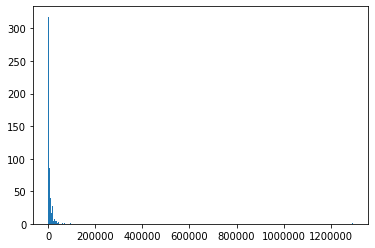

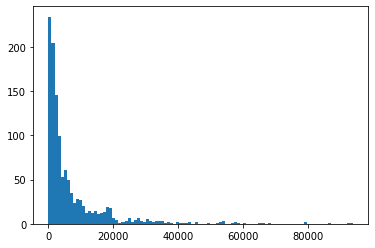

In [8]:
plt.hist(orders['revenue'], bins=1000)
plt.show()

#из-за заказа в 1 млн руб и 200 000 на гистограмме очень трудно понять что-то из-за
# масштаба, уберем его, чтобы лучше увидеть распределение заказов

plt.hist(orders[orders['revenue'] < 200000]['revenue'], bins=100)
plt.show()


Теперь мы лучше видим, что подавляющее большинство заказов меньше 10 000 руб и что очень мало заказов больше 20 000 руб. <br><br>
Постоим точечный график    

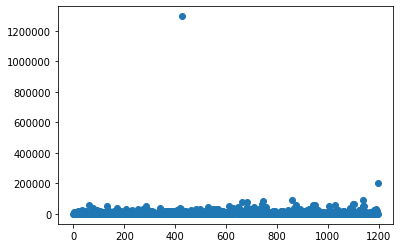

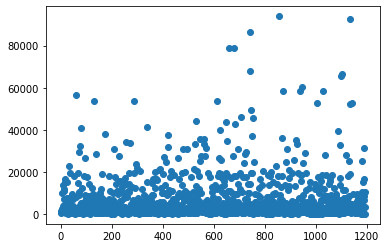

In [9]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.show()

x1_values = pd.Series(range(0, len(orders[orders['revenue'] < 200000]['revenue'])))
plt.scatter(x1_values, orders[orders['revenue'] < 200000]['revenue'])


Вот и стали видны два самых дорогих заказа: более 1,2 млн руб и 200 000 руб.  <br>
На второй точечной диаграмме мы увидели, что большинство наших заказов лежит в области меньше 10000 руб. Основная часть заказов - меньше 20 тыс руб. 

In [10]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])


Не более 5% заказов дороже 28 000 руб и не более 1% дороже 58 000 руб. Без разбивки данных по перцентилям, при "чистке" данных мы бы ориентрировались на более большие цифры, под влиянием более дорогих заказов, хотя 95% всех заказов меньше 30 000 руб. Надо проверить два самых дорогих заказа, чтобы убедиться, что это не бага в системе.

#### Вывод

На сырых данных стоимостей заказов мы не получили статистическое различие между группами А и В. Данные распределены не нормально и имеют выбросы. При разбивке сумм чеков по 95 и 99 перцентилям, получаем результат, что не более 5% заказов дороже 28 000 руб и не более 1% дороже 58 000 руб. В дальнейшем мы отбросим покупки, дороже 28 000.

### Проверка распределения заказов  по пользователям

Сделаем теперь все то же самое для оценки распределения заказов по пользователям. 

In [11]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users.columns = ['user_id', 'orders']

orders_by_users.sort_values(by='orders', ascending=False).head(10)

np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

 
Не более 5% всех пользователей сделало больше двух покупок за наблюдаемый период и не более 1% - более четырех.

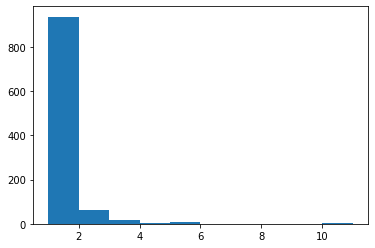

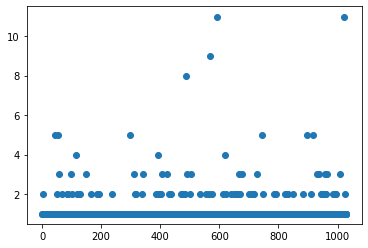

In [12]:
plt.hist(orders_by_users['orders'])
plt.show()

x_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x_values, orders_by_users['orders'])
plt.show()


На гистограмме и точечном графике мы видим много заказов, совершенных 1-3 раза. Есть выбросы пользователей, которые заказали 8, 9, 11 раз. Выберем 4 заказа как нижнюю границу и отсеем аномальных пользователей. 

#### Вывод
Не более 5% всех пользователей сделало больше двух покупок за наблюдаемый период и не более 1% - более четырех. Выберем 4 заказа как нижнюю границу и отсеем аномальных пользователей.

### Построение кумулятивных графиков

Объединим таблицы visitors и orders для дальнейшей статистической обработки

In [13]:

visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_a_daily']

visitors_a_cum = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']]
    .agg({'date': 'max', 'visitors_a_daily': 'sum'}),
    axis=1,
)
visitors_a_cum.columns = ['date', 'visitors_cum_a']
visitors_a_cum.head()

,date,visitors_cum_a
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [14]:
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_b_daily']

visitors_b_cum = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']]
    .agg({'date': 'max', 'visitors_b_daily': 'sum'}),
    axis=1,
)
visitors_b_cum.columns = ['date', 'visitors_cum_b']
visitors_b_cum.head()

,date,visitors_cum_b
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [15]:
#orders = orders[orders['revenue'] < 28000] - эта строчка нужна была, чтобы построить графики, 
# без учета дорогих покупок
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cum = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']]
    .agg({'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}),
    axis=1,
).sort_values(by=['date'])

orders_a_cum.columns = [
    'date',
    'orders_cum_a',
    'revenue_cum_a'
]

orders_a_cum.head()

,date,orders_cum_a,revenue_cum_a
0,2019-08-01,24,148579
1,2019-08-02,44,242401
2,2019-08-03,68,354874
3,2019-08-04,84,425699
4,2019-08-05,109,549917


In [16]:
orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cum = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']]
    .agg({'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}),
    axis=1,
).sort_values(by=['date'])

orders_b_cum.columns = [
    'date',
    'orders_cum_b', 
    'revenue_cum_b'
]

orders_b_cum.head()


,date,orders_cum_b,revenue_cum_b
0,2019-08-01,21,101217
1,2019-08-02,45,266748
2,2019-08-03,61,380996
3,2019-08-04,78,489567
4,2019-08-05,101,581995


In [17]:
data = (
    orders_a_daily.merge(
    orders_b_daily, left_on='date', right_on='date', how='left'
)
     .merge(orders_a_cum, left_on='date',right_on='date', how='left')
     .merge(orders_b_cum, left_on='date', right_on='date', how='left')
     .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
     .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
     .merge(visitors_a_cum, left_on='date', right_on='date', how='left')
     .merge(visitors_b_cum, left_on='date', right_on='date', how='left')
)

data.head()

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cum_a,revenue_cum_a,orders_cum_b,revenue_cum_b,visitors_a_daily,visitors_b_daily,visitors_cum_a,visitors_cum_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280



мы получили таблицу, содержащую с себе ежедневное и куммулятивное количество посещений, заказов и общую сумму заказов групп А и В. <br>
Постоим график кумулятивной выручки и кумулятивного среднего чека по группам. 

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


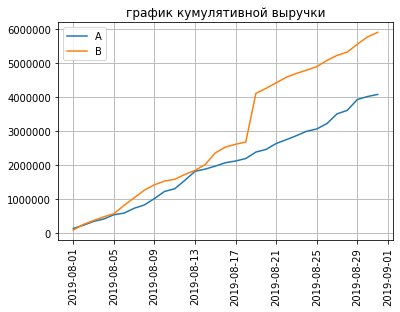

In [18]:
cum_revenue_a = data[['date', 'orders_cum_a', 'revenue_cum_a', 'visitors_cum_a']]
cum_revenue_b = data[['date', 'orders_cum_b', 'revenue_cum_b', 'visitors_cum_b']]

plt.plot(cum_revenue_a['date'], cum_revenue_a['revenue_cum_a'], label='A')

plt.plot(cum_revenue_b['date'], cum_revenue_b['revenue_cum_b'], label='B')

plt.title('график кумулятивной выручки')
plt.legend()
plt.xticks(rotation=90)
plt.grid()

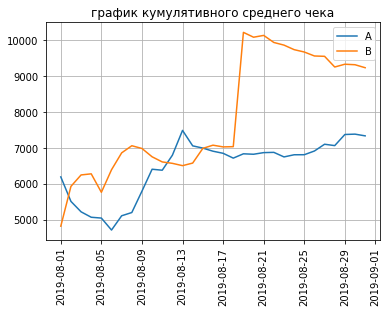

In [19]:
plt.plot(cum_revenue_a['date'],
        cum_revenue_a['revenue_cum_a'] / cum_revenue_a['orders_cum_a'],
        label='A')

plt.plot(cum_revenue_b['date'],
        cum_revenue_b['revenue_cum_b'] / cum_revenue_b['orders_cum_b'],
        label='B')

plt.title('график кумулятивного среднего чека')
plt.legend()
plt.xticks(rotation=90)
plt.grid()


мы получили два графика: график кумулятивной выручки и график кумулятивного чека. На графике кумулятивной выручки мы видим постепенный рост группы А. График группы В в нескольких местах резко растет - это связано с наличием нескольких дорогих покупок. И график кумулятивного среднего чека это подтверждает - группа В имеет резкий скачек среднего чека 18-го августа. График группы А стал более равномерным 13го августа и начал постепенно расти. Сделать однозначный вывод мы не можем, так как необходимо убрать выбросы. <br><br><br>
Построим график относительного изменения кумулятивного среднего чека группы B к группе A.
 

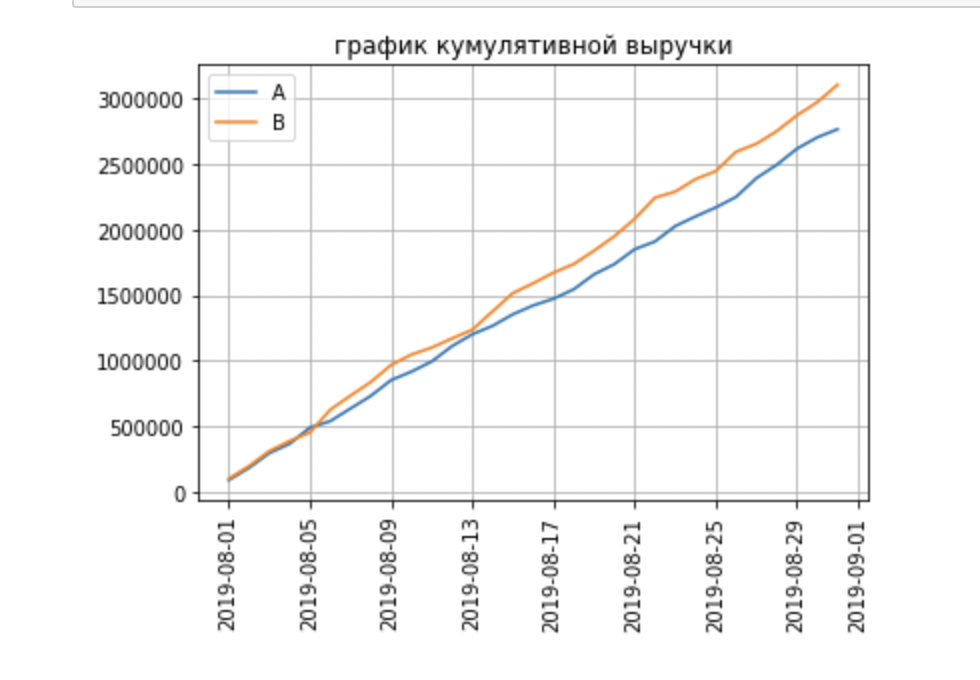









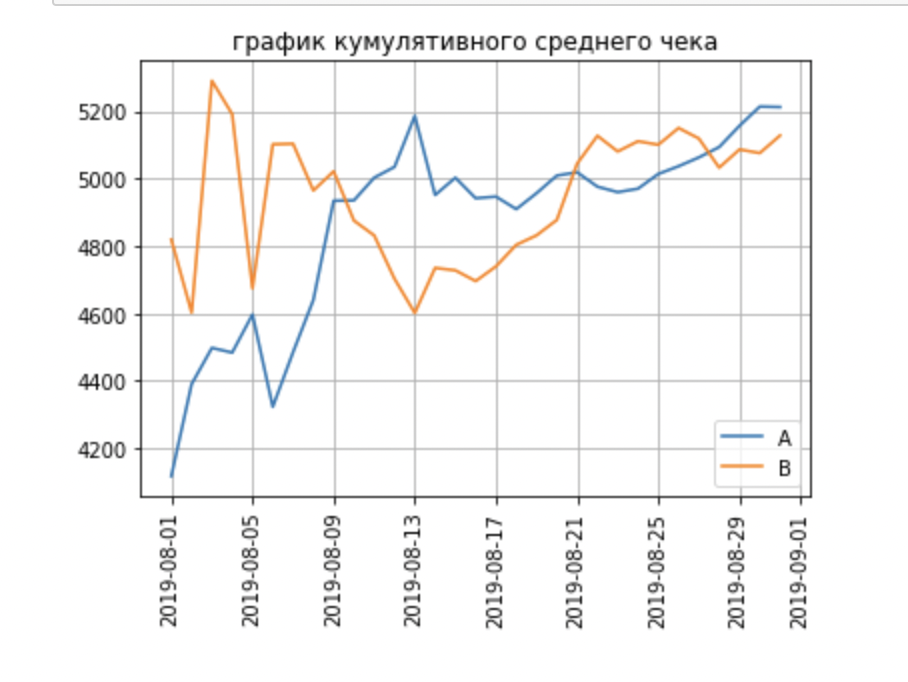

это два графика, полученные при фильтрации таблицы orders['revenue'] < 28 000. <br>
Сразу график кумулятивной выручки выравнивается в двух группах: вначале выручка в группе А и В равны, однако потом выручка в группе В становится больше. <br>
График кумулятивного среднего чека не так однозначен: группа В вначале показывает хороший результат, но потом падает и снова растет. Группа А растет на протяжении всего месяца наблюдения.
 

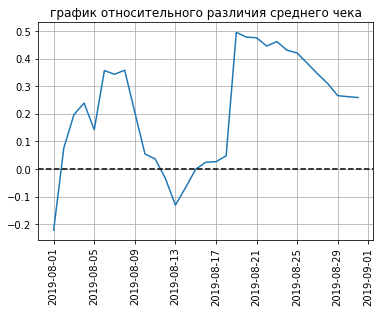

In [20]:
merged_cum_revenue = cum_revenue_a.merge(cum_revenue_b, 
                    left_on='date',
                    right_on='date',
                    how='left',
                    suffixes=['A', 'B']
)
merged_cum_revenue.head()

plt.plot(merged_cum_revenue['date'],
        (merged_cum_revenue['revenue_cum_b'] / merged_cum_revenue['orders_cum_b']) /
        (merged_cum_revenue['revenue_cum_a'] / merged_cum_revenue['orders_cum_a']) - 1 
)

plt.title('график относительного различия среднего чека')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=90)
plt.grid()

Опять же, из-за крупных заказов в нескольких точках график различия между сегментами резко «скачет».  <br><br><br>
Постройте график кумулятивной конверсии по группам и график относительного изменения кумулятивной конверсии группы B к группе A.

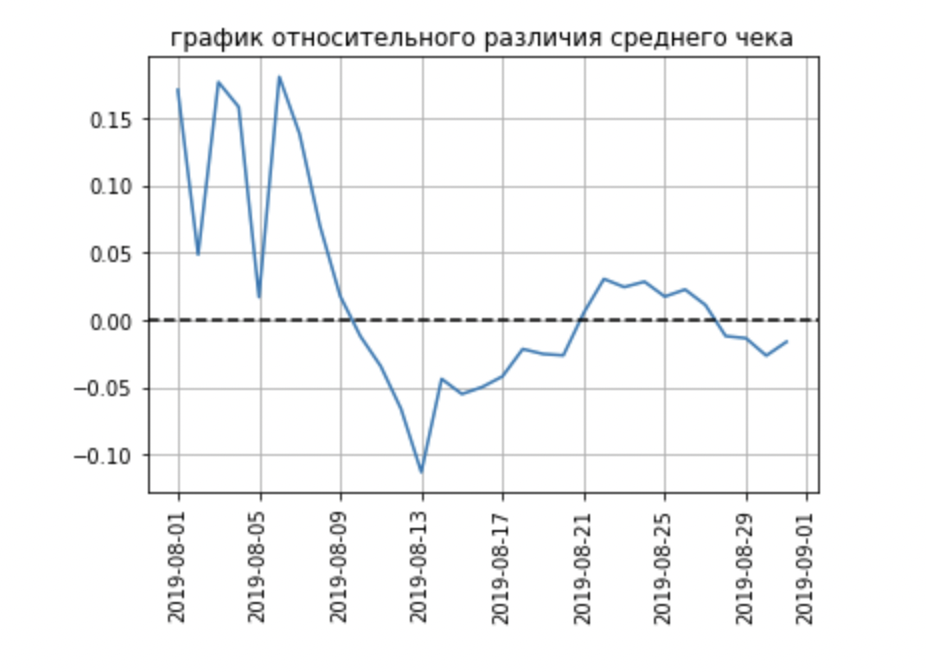

аналогичный график при условии orders['revenue'] < 28 000. <br>
Можно сказать, что он повторяет полебания графика кум среднего чека: вначале рост среднего чека группы В, затем ее небольшой рост и снова падениие. Однако сразу бросается в глаза, что, убрав крупные чеки, фактически исчезает прирост среднего чека группы В. 
 

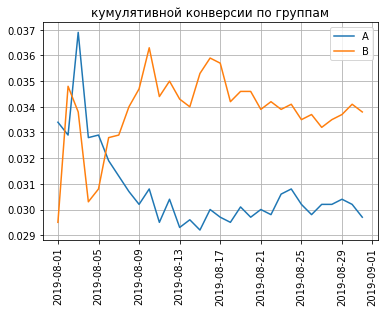

In [21]:
merged_cum_revenue['cum_conversion_a'] = (
    merged_cum_revenue['orders_cum_a'] / 
    merged_cum_revenue['visitors_cum_a']
    ).round(4)

merged_cum_revenue['cum_conversion_b'] = (
    merged_cum_revenue['orders_cum_b'] / 
    merged_cum_revenue['visitors_cum_b']
    ).round(4)


plt.plot(merged_cum_revenue['date'], merged_cum_revenue['cum_conversion_a'], label='A')
plt.plot(merged_cum_revenue['date'], merged_cum_revenue['cum_conversion_b'], label='B')

plt.title('кумулятивной конверсии по группам')
plt.legend()
plt.xticks(rotation=90)
plt.grid()



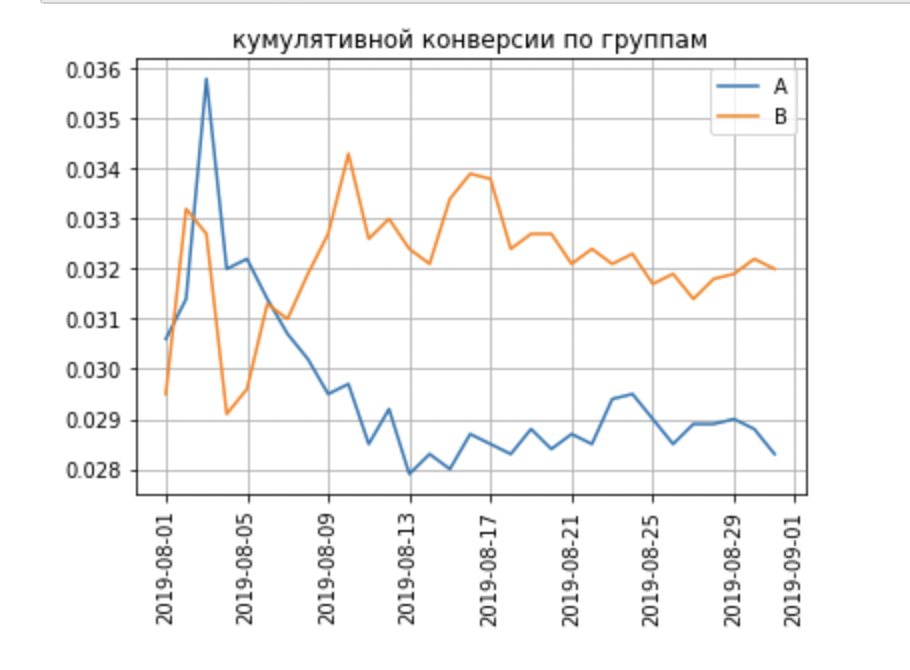

Высокие покупки никак не отразились на уровне конверсии в группах, так и на относительном приросте конверсии группы В относительно группы А.
 

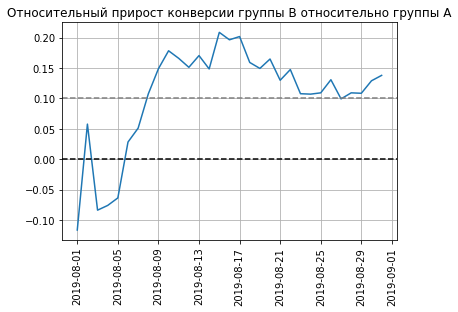

In [22]:
plt.plot(merged_cum_revenue['date'],
        (merged_cum_revenue['cum_conversion_b'] / merged_cum_revenue['cum_conversion_a'] -1)
        )

plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.xticks(rotation=90)
plt.grid()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')

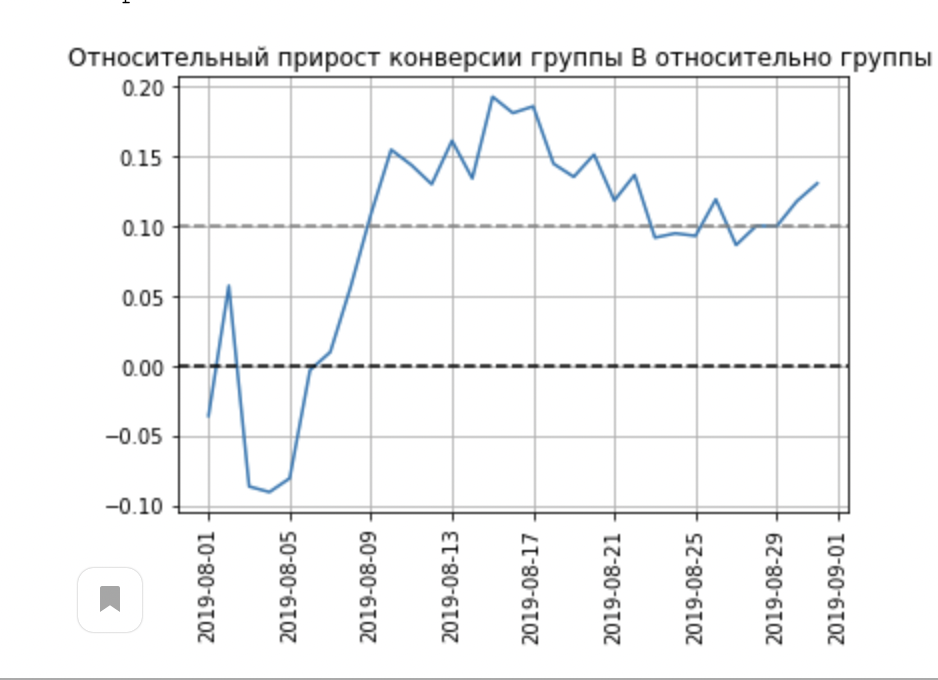

#### Вывод
Статистической разницы между средним чеком группы А и В нет, на графиках мы видим, что кум выручка и кум конверсия группы В выше , чем группы А. Но средний чек группы А выше, чем группы В.

### Оценка статистической значимости различий в конверсии между группами по «сырым» данным
Применим непараметрический U-критерий Манна-Уитни
для оценки различий конверсий в группах А и В.<br> Нулевая гипотеза (if results.pvalue > alpha) - разница статистически не значима, мы не может отвергнуть нулевую гипотезу. <br> Альтернативная гипотеза (if results.pvalue < alpha) - разница статистически значима, отвергаем нулевую гипотезу.

In [23]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['user_id', 'orders']

In [24]:
sample_a = pd.concat([orders_by_users_a['orders'],
    pd.Series(0, 
    index=np.arange(data['visitors_a_daily'].sum() - 
    len(orders_by_users_a['orders'])), name='orders')], axis=0)


sample_b = pd.concat([orders_by_users_b['orders'],
    pd.Series(0, 
    index=np.arange(data['visitors_b_daily'].sum() - 
    len(orders_by_users_b['orders'])), name='orders')], axis=0)


In [25]:
'{0:.3f}'.format(st.mannwhitneyu(sample_a, sample_b)[1])

'0.008'

In [26]:
'{0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1)


'0.138'

pvalue конверсии значительно меньше 0,05. Значит, принимаем альтернативную гипотезу - разница между конверсиями статистически значима. Группа В лидирует по отношению к группе А в уровне конверсии на 13.8%. Хотя средний чек группы В получился выше (см пункт 4), чем у группы А, это можно объяснить тем, что в группе В были сделаны дорогие заказы, увеличивающее средний чек.

#### Вывод
Статистическая разница конверсий групп А и В есть. Группа В имеет большую конверсию, чем группа А. 


### Оценка статистической значимости различий в конверсии и среднего чека между группами по "очищенным" данным
Выделим всех пользователей, совершивших более четырех заказов и всех пользователей, совершивших покупку на сумму более 28 000 руб. 

In [29]:
users_many_orders = pd.concat(
    [
    orders_by_users_a[orders_by_users_a['orders'] > 4]['user_id'],
    orders_by_users_b[orders_by_users_b['orders'] > 4]['user_id'],
    ],
    axis=0,
)

users_exp_orders = orders[orders['revenue'] > 28000]['visitor_id']

abnormal_users = (
    pd.concat([users_many_orders, users_exp_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormal_users.head()  
abnormal_users.shape

(59,)

 
Всего мы выявили 59 аномальных пользователей

In [32]:
sample_a_filtred = pd.concat([orders_by_users_a[
    np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))
    ]['orders'],
        pd.Series(0, 
              index=np.arange(
        data['visitors_a_daily'].sum() - len(orders_by_users_a['orders'])),
        name='orders')], axis=0
)

sample_b_filtred = pd.concat([orders_by_users_b[
    np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))
    ]['orders'],
        pd.Series(0, 
                 index=np.arange(
                 data['visitors_b_daily'].sum() - len(orders_by_users_b['orders'])),
        name='orders')], axis=0
)

'{0:.3f}'.format(st.mannwhitneyu(sample_a_filtred, sample_b_filtred)[1])
'{0:.3f}'.format(sample_b_filtred.mean()/sample_a_filtred.mean()-1)

'0.145'

Как мы видим, результаты по конверсии фактически не изменились, посмотрим, изменился ли средний чек

In [35]:
mean_check_b_filtred = orders[
    np.logical_and(orders['group'] == 'B',
    np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue']

mean_check_a_filtred = orders[
    np.logical_and(orders['group'] == 'A',
    np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue']



'{0:.5f}'.format(st.mannwhitneyu(mean_check_a_filtred,
    mean_check_b_filtred)[1]
)

# '{0:.3f}'.format(
#     mean_check_b_filtred.mean() /
#     mean_check_a_filtred.mean() -1
# )

'0.48064'

Как мы видим, результаты после "очистки" данных от аномалий статистической разницы между двумя чеками не найдено - p-value > 0.05. Однако на графике не ясно, стабилизировался ли средний чек или нет. В идеале еще посмотреть несколько недель, как поведет себя средний чек, а потом уже принимать решения.

## Общий вывод
По результам теста мы можем сказать следующее:<br>
1.  статистически значимая разница по конверсии между группами А и В есть по "сырым" и по "очищеннным" данным. <br>
2. по "сырым" и по "очищеннным" данным нет статистической разницы между группами по среднему чеку. Однако график изменения среднего чека еще не стабилизировался, и пока не ясно,как он поведет себя в будующем <br>
3.А/В тестирование можно прекратить, так как разницы между средними чеками нет, но конверсия группы В выше, чем группы А.    